# CubePlusPlus Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance


Imagecount: `ls | wc -w` => `4890`
JPG Dataset size: 2544466KB = 2544.466MB = 
JPG Average image size: 520.3406952965236KB ~= 0.52MB
JPG Exact resolution: 2592x1728

* Dataset size: `2.544466 GB` (`cubeplusplus/JPEG> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `4890` (`cubeplusplus/JPEG> ls | wc -w`)
* Avg. filesize: `0.5203406952965236KB MB`
* Resolution: `2592x1728`
* Sample sizes (rounded to second decimal):
    * `   0500:       260.17 MB` 
    * `   1000:       520.34 MB`
    * `   2000:      1040.68 MB`
    * `   4000:      2081.36 MB`
    * `   4890:      2544.46 MB` 

In [1]:
full_dataset_samplecount = 4890
for sample_size in [500, 1000, 2000, 4000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")
    print(f"{sample_size} in MB: {round(sample_size * 0.5203406952965236,2)}MB")

500 of total: 10.22%
500 in MB: 260.17MB
1000 of total: 20.45%
1000 in MB: 520.34MB
2000 of total: 40.9%
2000 in MB: 1040.68MB
4000 of total: 81.8%
4000 in MB: 2081.36MB


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import matplotlib.patches as mpatches
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')
from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "cubeplusplus-jpg-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/cubeplusplus/jpg/main-experiments"
path_to_cum_df = f"{home_path}/cubeplusplus-caching-jpg-storage-ceph-hdd_2021-10-03-00:17:26_cum-df_samples-500-1000-2000-4000-4890_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/cubeplusplus-caching-jpg-storage-ceph-hdd_2021-10-03-00:17:26_cum-dstat-df_samples-500-1000-2000-4000-4890_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "concatenated", "decoded", "resized", "pixel-\ncentered"]

In [4]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
0,0.0,8,8,0.0,4890,69.548386,70.310760,0,3,b67ba6,0-fully-online,2021-10-01-11:28:32,none,ceph-hdd
1292,0.0,1,1,0.0,1000,55.679714,17.959862,2,3,be4e90,0-fully-online,2021-10-03-21:53:44,none,ceph-hdd
572,0.0,4,4,0.0,4000,35.567535,112.462112,2,3,08f41c,0-fully-online,2021-10-03-09:49:36,none,ceph-hdd
992,0.0,1,1,0.0,1000,57.720451,17.324881,2,3,055ac6,0-fully-online,2021-10-03-16:32:38,none,ceph-hdd
991,0.0,1,1,0.0,1000,61.847919,16.168692,1,3,055ac6,0-fully-online,2021-10-03-16:32:38,none,ceph-hdd


In [5]:
cum_dstat_df.columns

Index(['rel_time_s', 'disk_read_mbs', 'disk_write_mbs', 'net_read_mbs',
       'net_write_mbs', 'run', 'sample_count', 'shard_count', 'thread_count',
       'ueid', 'split_name', 'creation_timestamp', 'cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent',
       'system_interrupts_per_s', 'system_context_switches_per_s',
       'memory_free_mb', 'memory_buffered_mb', 'memory_used_mb',
       'memory_cached_mb', 'vm_major_pagefaults', 'vm_minor_pagefaults',
       'vm_allocated_mb', 'vm_free_mb', 'filesystem_files',
       'filesystem_inodes', 'filelocks_posix', 'filelocks_lock',
       'filelocks_read', 'filelocks_write', 'compression_type',
       'storage_type'],
      dtype='object')

## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g., `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [6]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
  , "runs_count": []
  , "runs_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count
              , runs_count, runs_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]
    experiment_count_dict["runs_count"] += [runs_count]
    experiment_count_dict["runs_experiment_count"] += [runs_experiment_count]


for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f"sample_count=={sample_count}"))
    # for each thread setting
    for thread_count in cum_df.query(f"sample_count=={sample_count}")['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)        
        # for each run (epoch)
        for runs_count in cum_df.query(f"sample_count=={sample_count} and thread_count=={thread_count}")['runs_count'].unique():
            runs_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count} and runs_count=={runs_count}'))
            add_to_dict(sample_count, sample_experiment_count,
                        thread_count, thread_experiment_count, norm_thread_experiment_count, runs_count, runs_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count,runs_count,runs_experiment_count
0,4890,375,8,150,30.0,0,50
1,4890,375,8,150,30.0,2,50
2,4890,375,8,150,30.0,1,50
3,4890,375,4,75,15.0,0,25
4,4890,375,4,75,15.0,1,25
5,4890,375,4,75,15.0,2,25
6,4890,375,2,75,15.0,1,25
7,4890,375,2,75,15.0,0,25
8,4890,375,2,75,15.0,2,25
9,4890,375,1,75,15.0,0,25


# 1. Storage Consumption vs Throughput Tradeoffs
### Full dataset, 8 threads, epoch 0

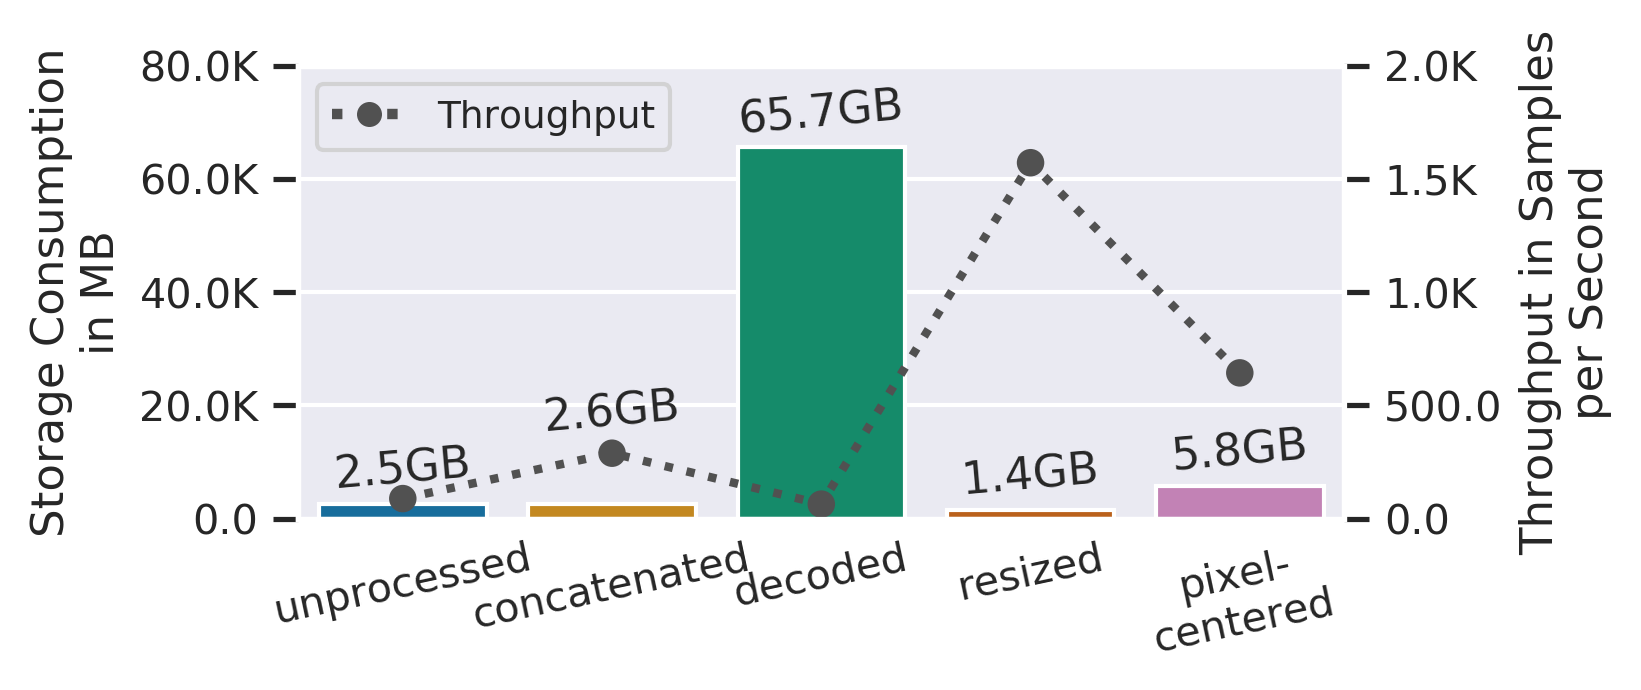

In [16]:
cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "500": 260.17
  , "1000": 520.34
  , "2000": 1040.68
  , "4000": 2081.36
  , f"{full_dataset_samplecount}": 2544.46
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.9)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()


## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 2000))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={full_dataset_samplecount}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=5000, rotation=5, additional_space=[0,10000,0,0,0], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 80000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput")

# 2. Caching Analysis
### Full dataset, 8 threads, epoch 0 + 1 + 2

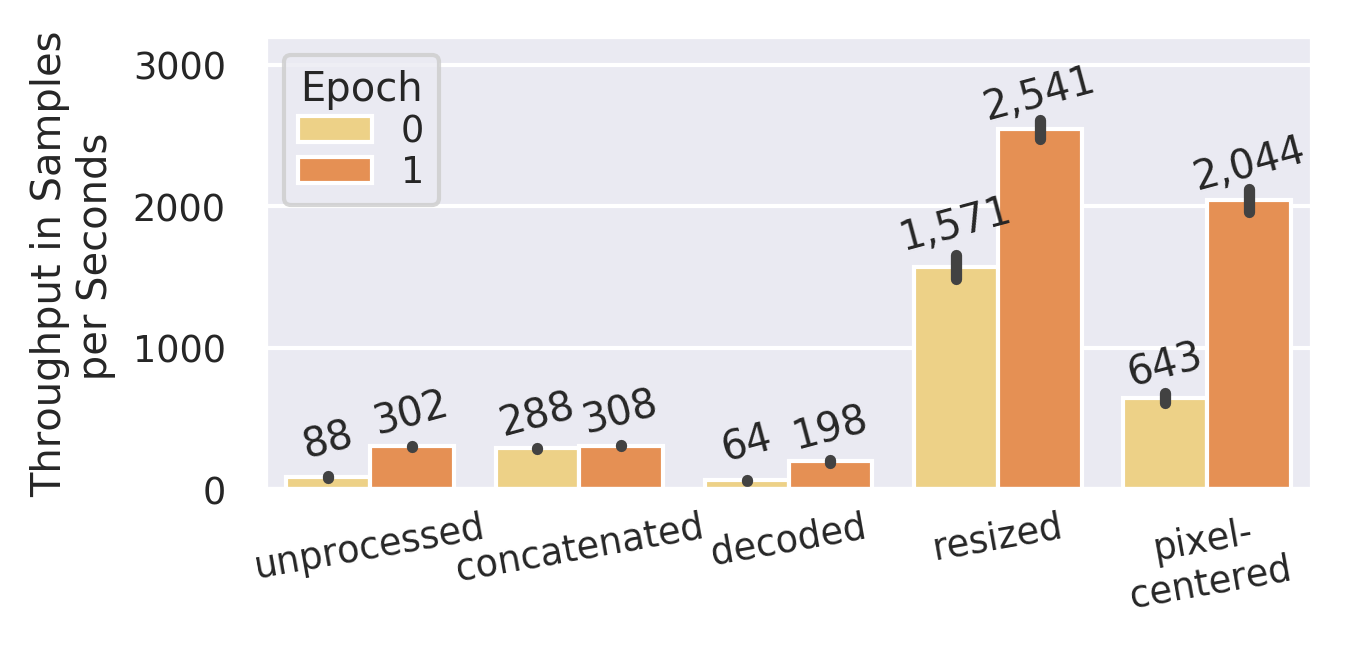

In [35]:
sns.set(palette=epoch_palette, font_scale=0.8)

cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 and runs_count<=1")

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Throughput in Samples\n per Seconds")
plot.set(ylim=(0, 3200))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=220, rotation=15, additional_space=[0,0,0,100,0
                                                                            ,0,0,0,50,50])
save_fig("caching-over-epochs")

# 3. Compression Analysis (other notebook)

# 4. Number of Samples
## 500, 1000, 2000, 4000, 4890 samples + 8 threads + epoch 0

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [8]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 4890, 'sample_count'] = '4.9K (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, '4.9K (full)': 14}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

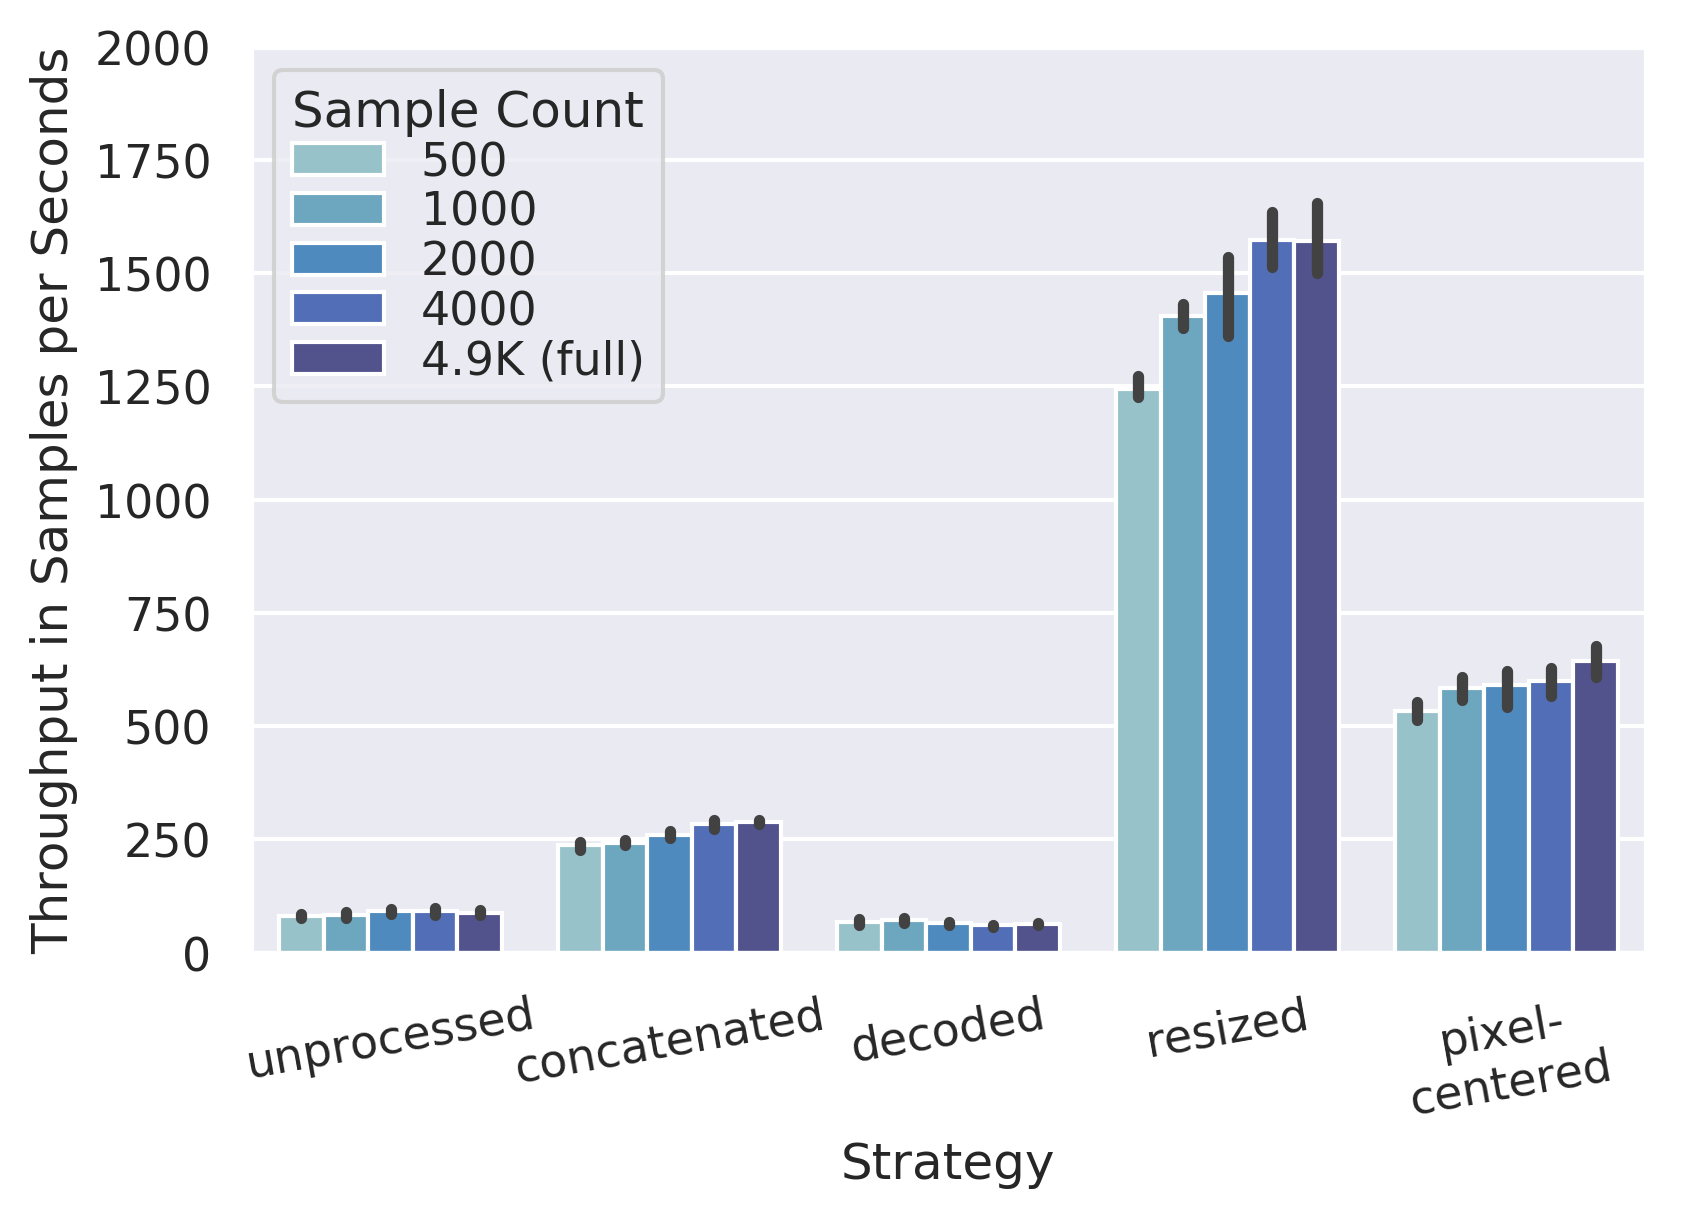

In [9]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0 \
                             and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 2000))
plot.legend(title="Sample Count", ncol=1, labelspacing=0.1)
save_fig("sampling-throughput")

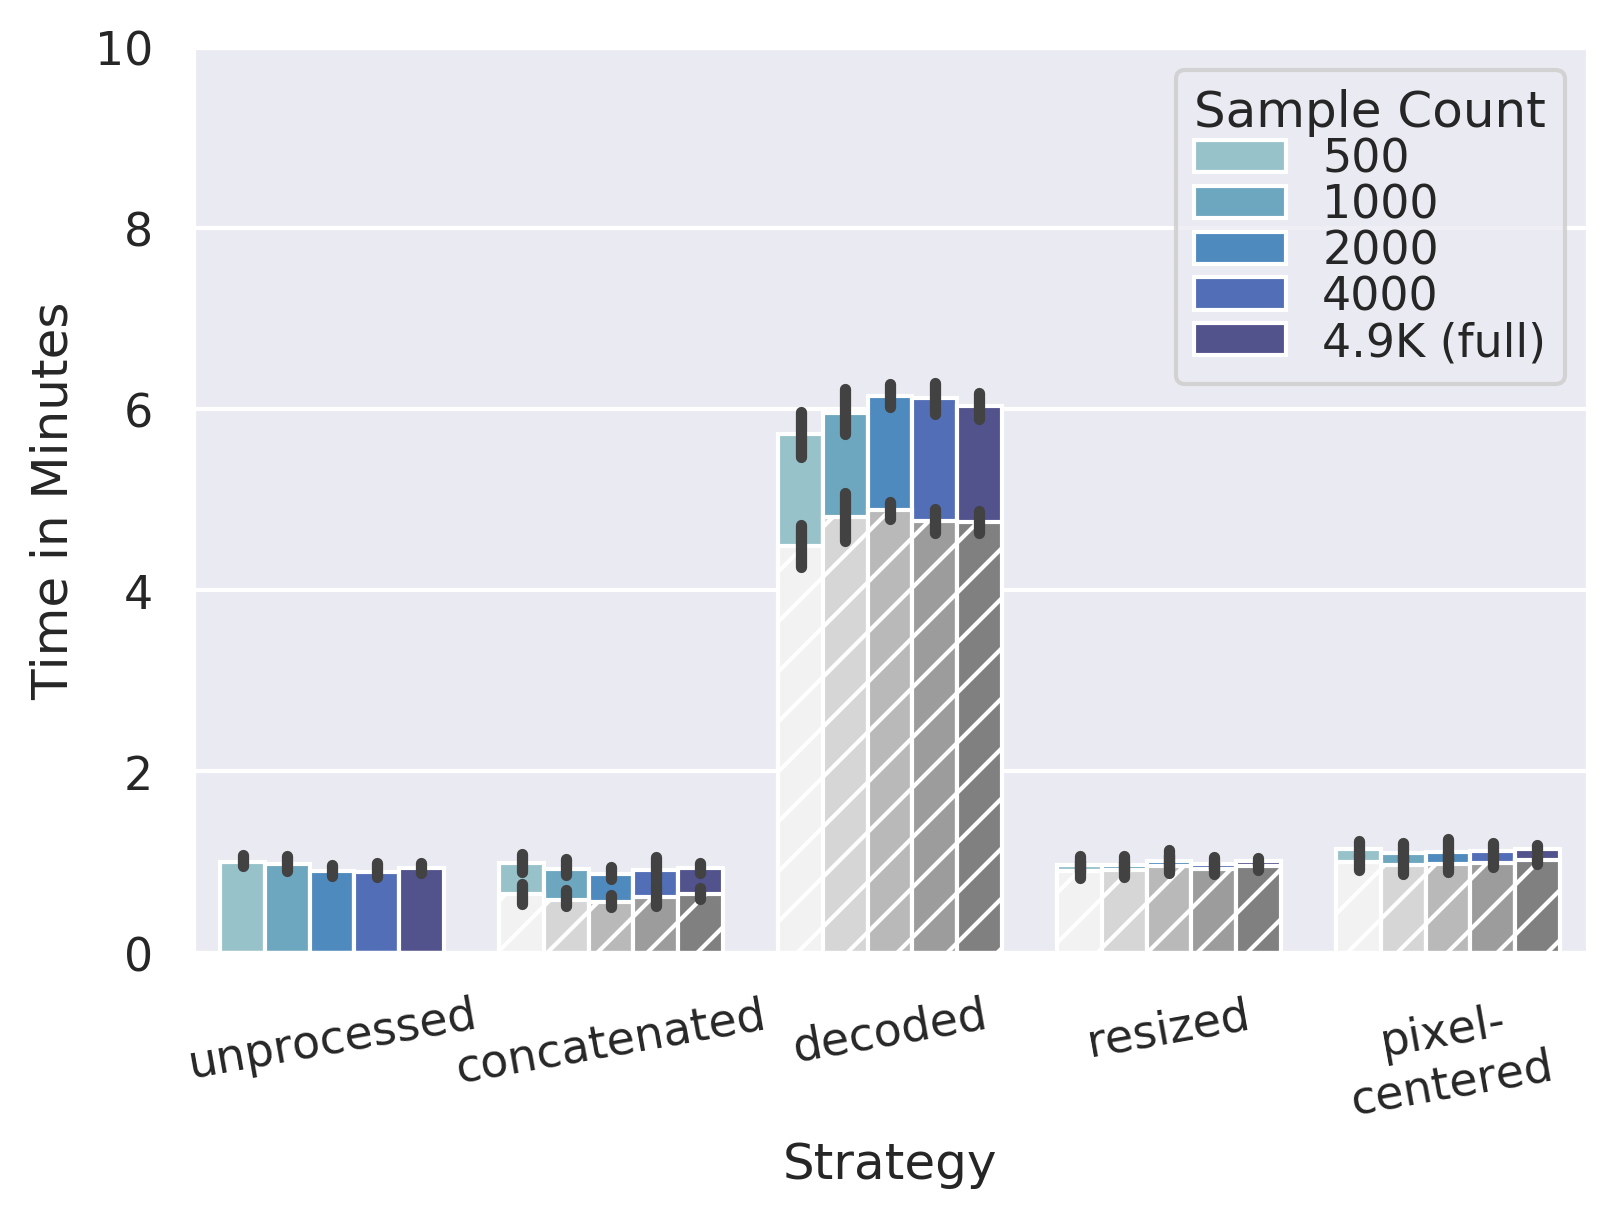

In [10]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0 \
                             and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_m",
    hue="sample_count",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_m",
    hue="sample_count",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)

sample_counts = len(cum_df_temp.sample_count.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="Strategy", ylabel="Time in Minutes")
plot.set(ylim=(0, 10))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper right", ncol=1, labelspacing=0.02, columnspacing=0.3)
save_fig("extrapolated-dataset-processing-time")

# 5. Speedup
## 4000 samples + 1, 2, 4, 8 threads + epoch 0
### Calculate the speedup 

In [12]:
cum_8000_df = cum_df_mod.query("sample_count=='4.9K (full)'")

parallel_capability = {
      "thread_count": []
    , "strategy": []
    , "speedup": []
    , "run": []
}

def add_capability(thread_count, strategy, speedup, run):
    parallel_capability["thread_count"] += [thread_count]
    parallel_capability["strategy"] += [strategy]
    parallel_capability["speedup"] += [speedup]
    parallel_capability["run"] += [run]

for strategy in strategies:
    for run_count in cum_df.runs_count.unique():
        for thread_count in cum_df.thread_count.unique():
            throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].to_numpy()
            for throughput in throughputs:
                avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].mean()
                # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                #if avg_step_t1_throughput < throughput:
                #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                #else:
                #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                ## now using speedup instead of increase/decrease factor
                speedup = throughput / avg_step_t1_throughput
                add_capability(thread_count, strategy, speedup, run_count)

parallel_capability_df = pd.DataFrame(parallel_capability)
parallel_capability_df

,thread_count,strategy,speedup,run
0,8,0-fully-online,5.241995,0
1,8,0-fully-online,7.470174,0
2,8,0-fully-online,7.057424,0
3,8,0-fully-online,7.217868,0
4,8,0-fully-online,6.452944,0
...,...,...,...,...
370,2,5-center-pixel-values,2.062703,1
371,2,5-center-pixel-values,1.693497,1
372,2,5-center-pixel-values,1.873915,1
373,2,5-center-pixel-values,1.701380,1


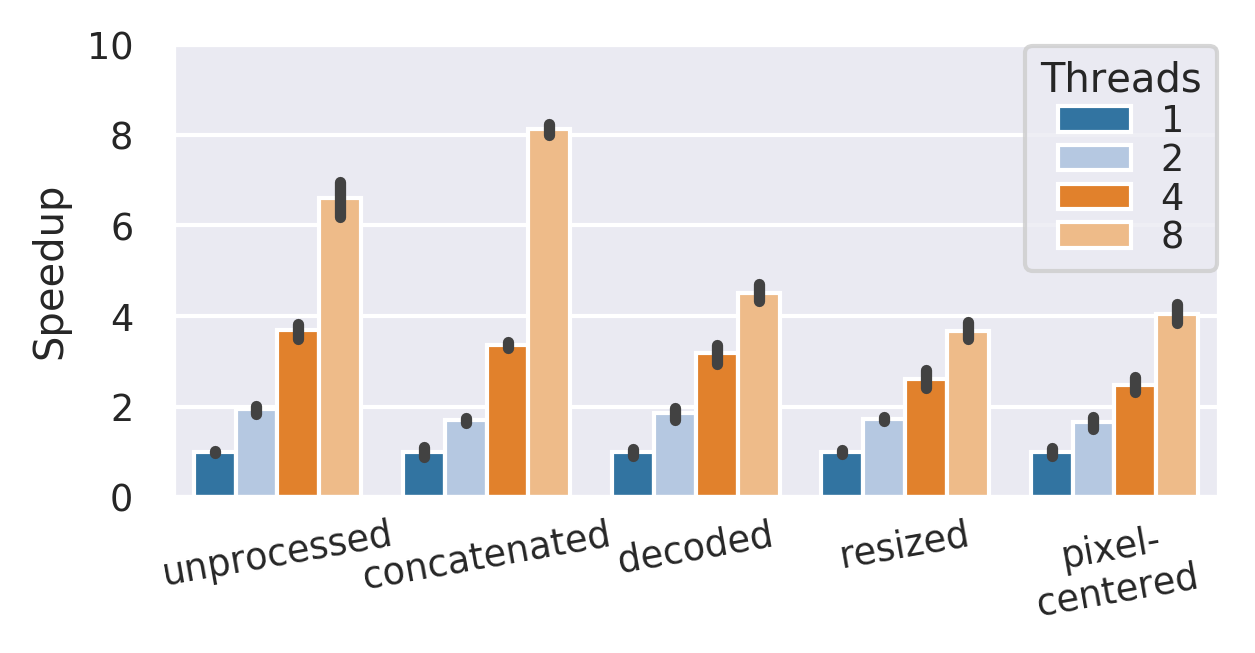

In [15]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==0")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 10))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-4890-samples-epoch-0")

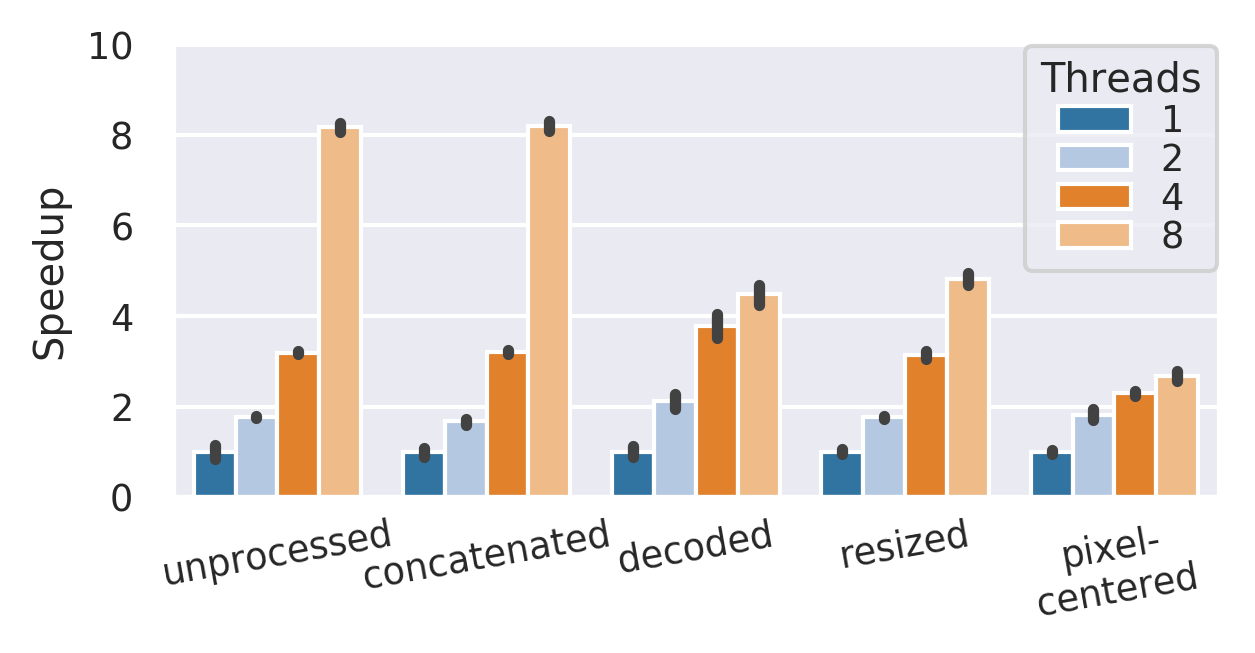

In [16]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==1")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 10))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-4890-samples-epoch-1")

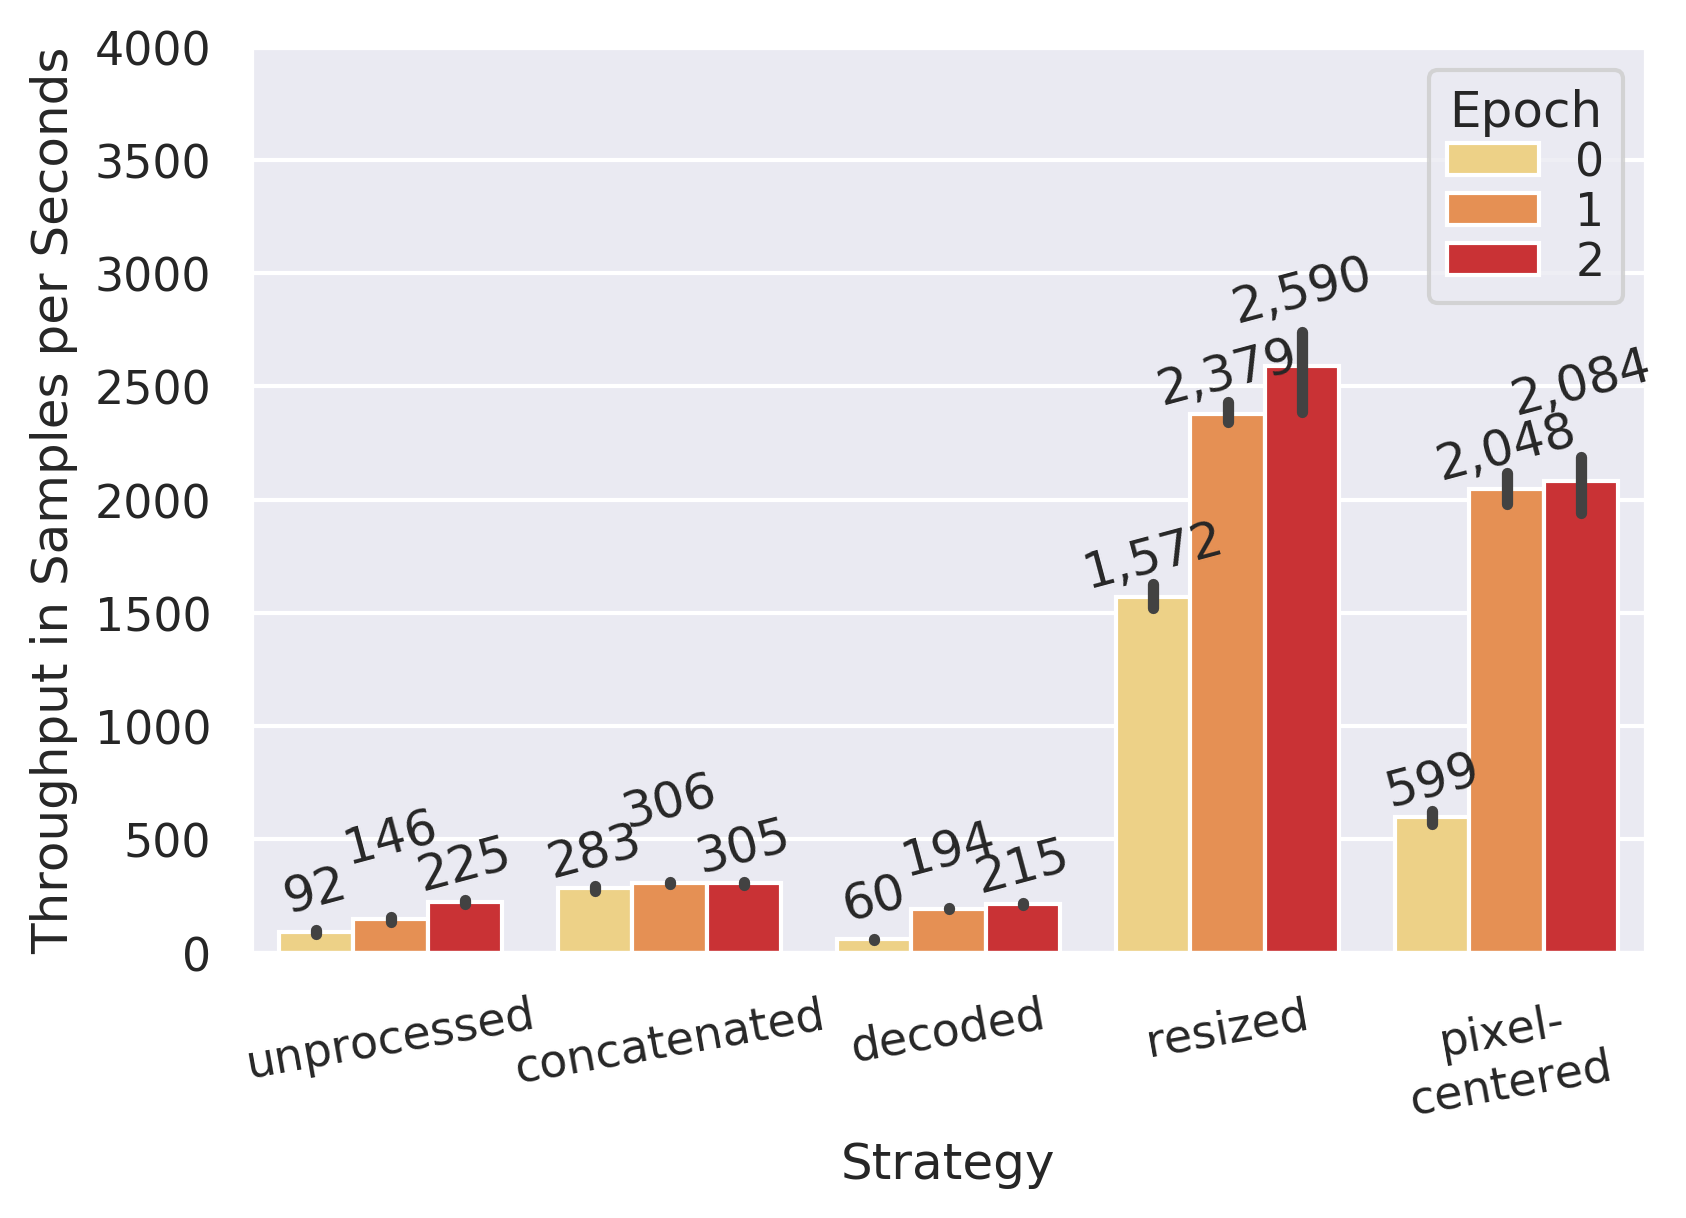

In [28]:
sns.set(palette=epoch_palette)
cum_df_temp = cum_df.query("sample_count==4000 and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 4000))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=100, rotation=15, additional_space=[50,   50,  50, 100,  50
                                                                            ,250, 250, 150, 100, 100
                                                                            ,50,   50,  50, 250, 350])
save_fig("throughput-4000-samples-epoch-0-1-2")

# X. Misc Plots and Calculations

## X.0 Automatic Extraction of all CPU-x times for online processing

In [100]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount
    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]

split_names = cum_df.split_name.unique()

frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]

online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
    
    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)
cumulative_cpu_df

,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,22.416582,38.504047,2.150015,45.954487,13.384068
std,16.378443,9.395724,0.853686,11.875042,3.295106
min,0.000000,0.000000,0.000000,26.190001,0.457000
25%,8.000000,35.094002,1.631000,38.972000,11.920000
50%,20.000000,40.452000,2.015000,43.521999,13.733000
75%,35.000000,44.556000,2.509000,49.686001,15.269000
max,69.000000,54.009998,8.712000,96.000000,23.868999


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,54.876545,80.914856,6.874135,11.998828,0.201383
std,3.899945,10.593741,5.024319,8.345097,1.339286
min,50.000000,2.381000,2.384000,5.772000,0.000000
25%,52.000000,78.167999,3.625000,9.000000,0.000000
50%,54.000000,82.746002,4.386000,10.818000,0.000000
75%,57.000000,86.072998,7.818000,12.907000,0.000000
max,66.000000,90.841003,17.997000,79.197998,10.777000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,647.000000,647.000000,647.000000,647.000000,647.000000
mean,336.517761,24.859159,19.057163,31.994940,24.025654
std,20.773418,5.613136,3.384409,9.205209,6.175883
min,305.000000,0.000000,8.281000,10.714000,-1.128000
25%,319.000000,22.020000,17.010500,26.498500,21.505500
50%,335.000000,24.937000,18.757999,30.489000,24.652000
75%,352.000000,27.645000,20.466000,35.889500,27.662500
max,392.000000,57.397999,35.308998,87.610001,50.320000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,12.00000,12.000000,12.000000,12.000000,12.000000
mean,63.25000,38.514248,17.404583,42.051167,1.998417
std,1.13818,15.906298,15.328424,20.418325,2.514204
min,62.00000,3.526000,5.025000,11.500000,-0.648000
25%,62.00000,34.100749,9.185250,33.127001,0.191250
50%,63.00000,39.490000,11.753500,40.916000,1.506500
75%,64.00000,44.297001,16.233250,51.559750,2.453750
max,65.00000,73.563004,49.750000,85.389999,8.417000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,69.677422,20.747164,13.120547,54.405941,11.685967
std,2.226913,9.935236,2.540872,9.323432,6.246072
min,67.000000,5.276000,7.882000,33.797001,2.387000
25%,68.000000,14.242500,11.188000,51.033499,7.541000
50%,69.000000,19.059999,13.033000,54.362000,10.114000
75%,71.000000,25.443001,14.493500,59.478001,15.238500
max,75.000000,46.716999,20.525999,82.538002,29.757000


,split_name,cpu_usr_cum,cpu_sys_cum,cpu_idle_cum,cpu_wait_cum
0,0-fully-online,38.504047,40.654063,86.608549,99.992617
1,2-read-image,80.914856,87.788991,99.787819,99.989202
2,3-decode-image,24.859159,43.916323,75.911263,99.936916
3,4-resize-image,38.514248,55.918831,97.969997,99.968414
4,5-center-pixel-values,20.747164,33.867711,88.273652,99.959620


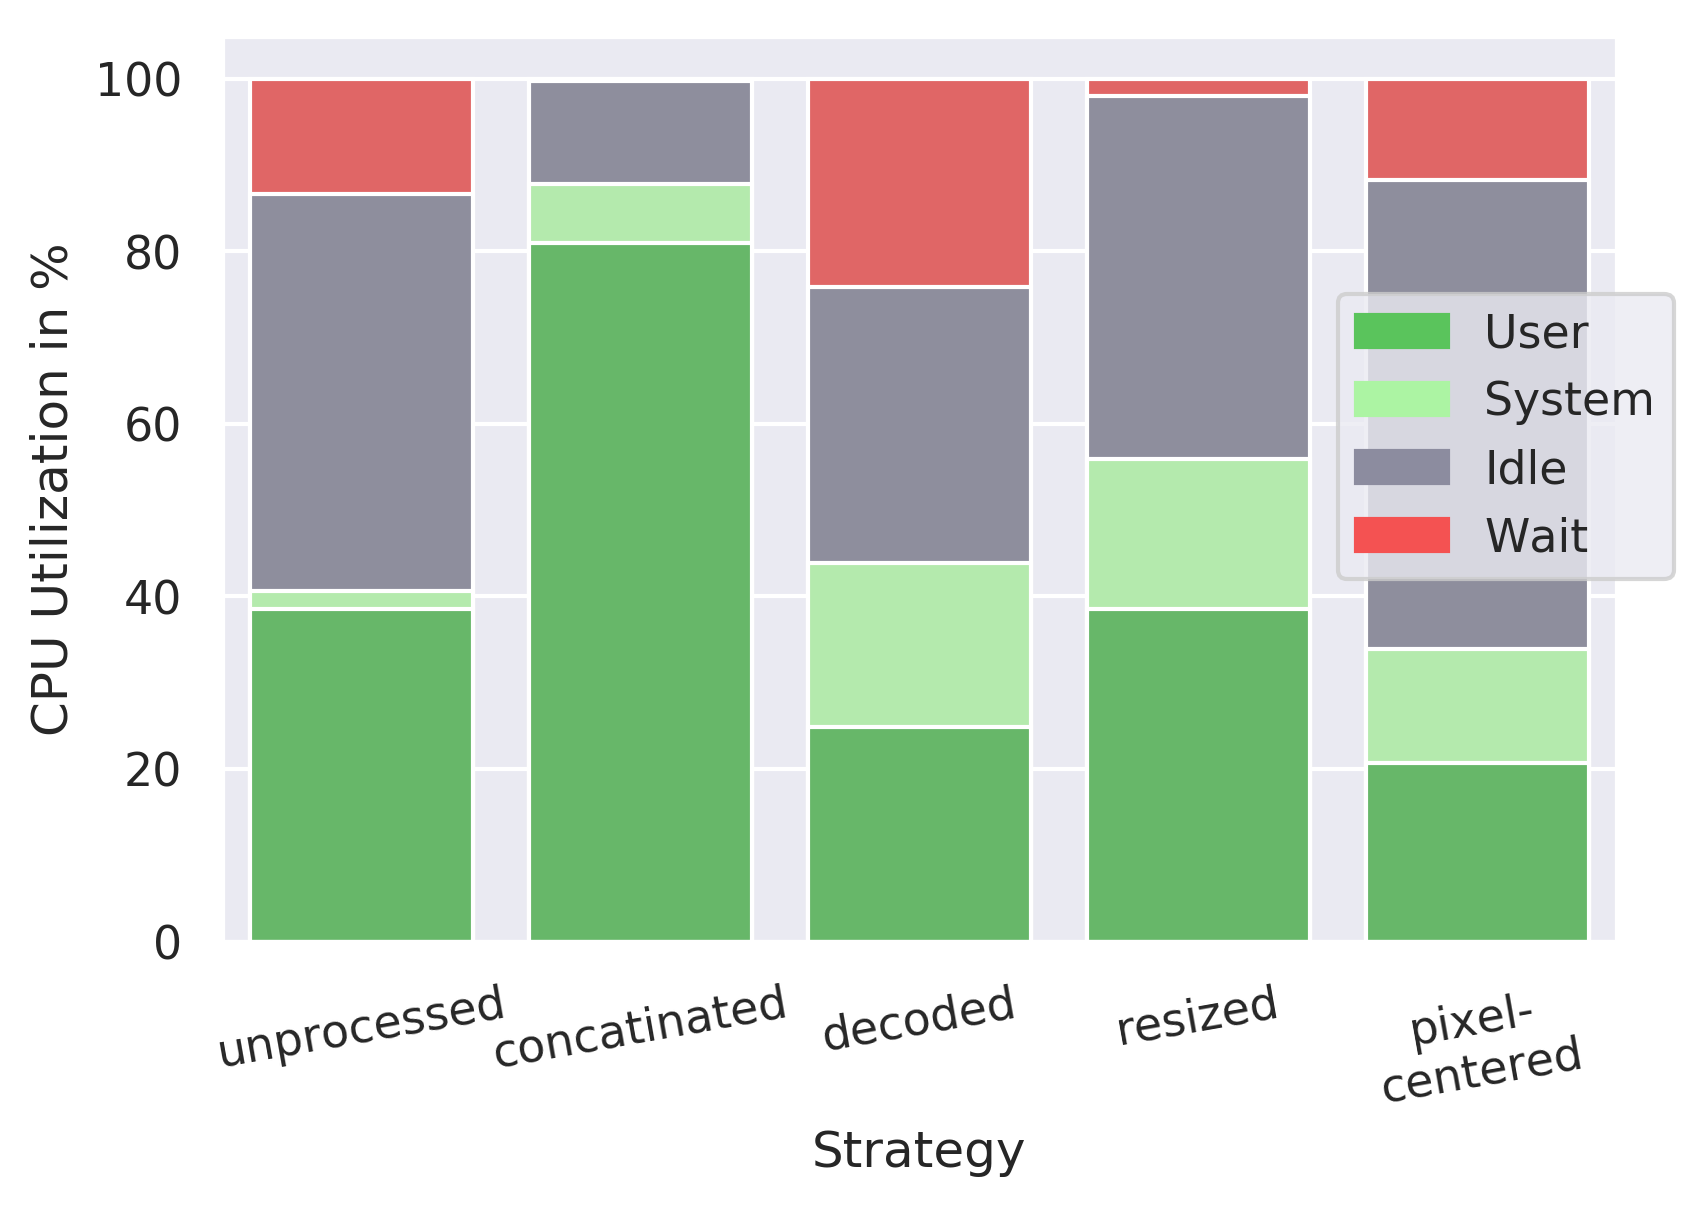

In [98]:
# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

# bar chart 1 -> top bars (group of 'smoker=No')


bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")
#plot.set(ylim=(0, 120))
#plot.legend(title="Epoch", ncol=1, labelspacing=0.1)

# bottom bar ->  take only smoker=Yes values from the data
#smoker = tips[tips.smoker=='Yes']

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
#bar2 = sns.barplot(x="day", y="total_bill", data=smoker, estimator=sum, ci=None,  color='lightblue')

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

## X.1 Calculation for Analysis - Network Throughput for Unprocessed vs Concatinated

In [41]:
cum_dstat_df.columns

Index(['rel_time_s', 'disk_read_mbs', 'disk_write_mbs', 'net_read_mbs',
       'net_write_mbs', 'run', 'sample_count', 'shard_count', 'thread_count',
       'ueid', 'split_name', 'creation_timestamp', 'cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent',
       'system_interrupts_per_s', 'system_context_switches_per_s',
       'memory_free_mb', 'memory_buffered_mb', 'memory_used_mb',
       'memory_cached_mb', 'vm_major_pagefaults', 'vm_minor_pagefaults',
       'vm_allocated_mb', 'vm_free_mb', 'filesystem_files',
       'filesystem_inodes', 'filelocks_posix', 'filelocks_lock',
       'filelocks_read', 'filelocks_write', 'compression_type',
       'storage_type'],
      dtype='object')

In [17]:
run = 0
threads = 8
sample_count = full_dataset_samplecount
unprocessed = '0-fully-online'
concatenated = '2-read-image'

test_dstat_df = cum_dstat_df.query(f"run=={run} and \
                                     thread_count=={threads} and \
                                     sample_count=={sample_count}")
unprocessed_dstat_df = test_dstat_df.query(f"split_name=='{unprocessed}'")

print("---------------------------------------")
print("-- Unprocessed CPU Wait in % --")
print(unprocessed_dstat_df.describe()["cpu_wait_in_percent"])

# because we have multiple runs and they dont stop at the same second, we take the maximum run and cut from there
# to average the network read speed
max_offline_processing_time_s = cum_df.query(f"split_name=='{concatenated}' and \
                     runs_count=={run} and \
                     thread_count=={threads} and \
                     sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()

concatenated_dstat_df = test_dstat_df.query(f"split_name=='{concatenated}' and \
                                              rel_time_s>={max_offline_processing_time_s}")
print("---------------------------------------")
print("-- Concatenated CPU Wait in % --")
print(concatenated_dstat_df.describe()["cpu_wait_in_percent"])

---------------------------------------
-- Unprocessed CPU Wait in % --
count    562.000000
mean      13.802119
std        3.049510
min        0.457000
25%       12.363500
50%       13.927000
75%       15.447250
max       23.868999
Name: cpu_wait_in_percent, dtype: float64
---------------------------------------
-- Concatenated CPU Wait in % --
count    71.000000
mean      0.229746
std       1.429447
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.777000
Name: cpu_wait_in_percent, dtype: float64


## X.2 Calculation for Analysis - Network Throughput for all strategies

In [40]:
def extract_online_processing_frames(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount
    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 55
count    989.000000
mean      46.066364
std       12.823936
min        0.000000
25%       40.865360
50%       48.281937
75%       54.632679
max       68.650436
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 16
count     81.000000
mean     111.588539
std       72.530746
min        0.000120
25%       17.898090
50%      149.472626
75%      163.726929
max      193.574722
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 76
count     647.000000
mean      828.355591
std       173.765411
min         0.000120
25%       790.548950
50%       847.380676
75%       930.394012
max      1138.651123
Name: net_read_mbs, dtype: float64
------------------------------

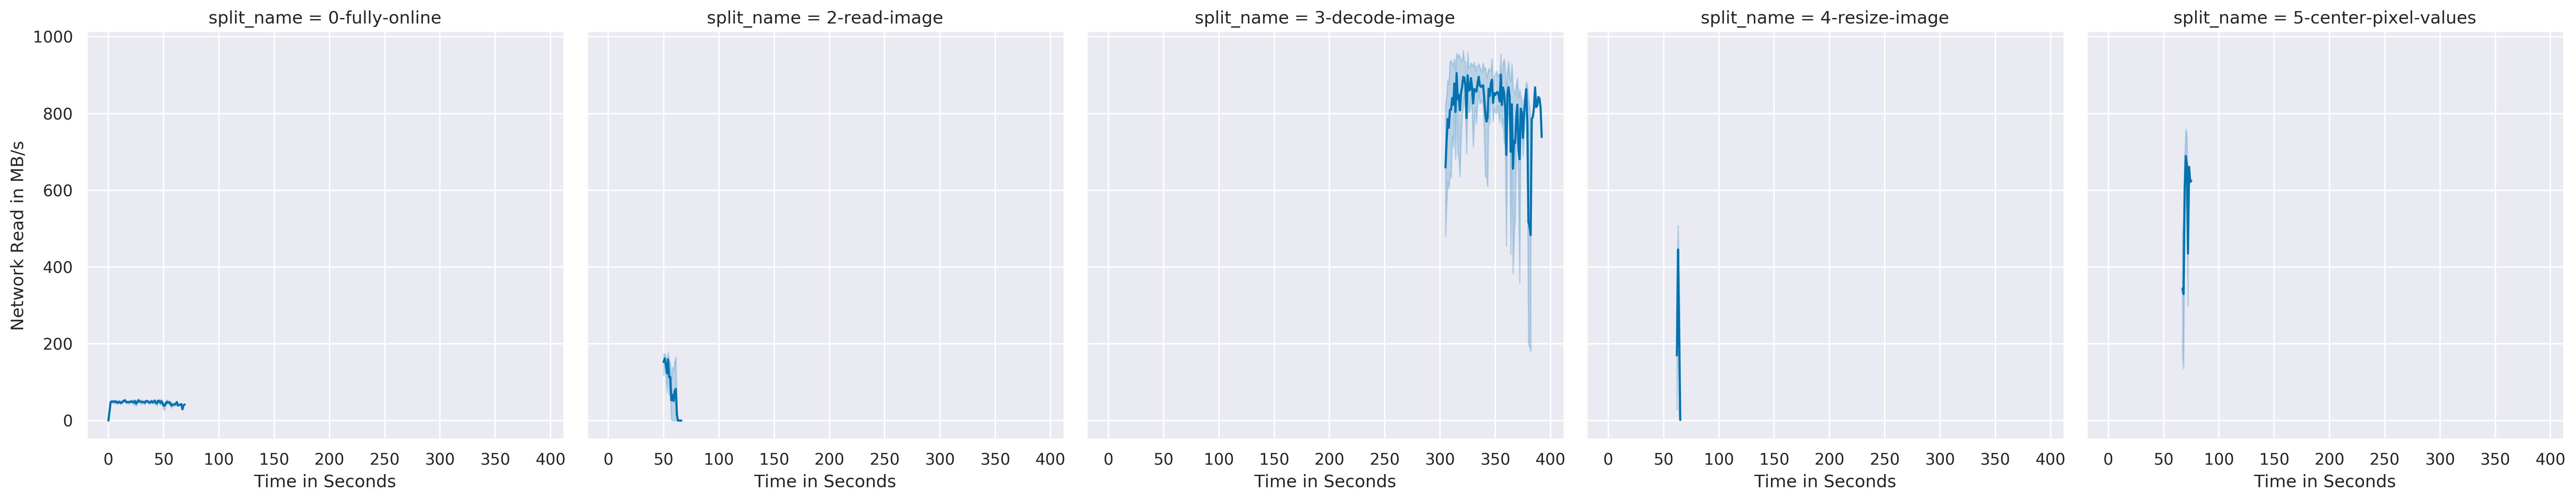

In [34]:
sns.set(palette=default_palette)

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="split_name",
    kind="line",
    data=online_df,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")

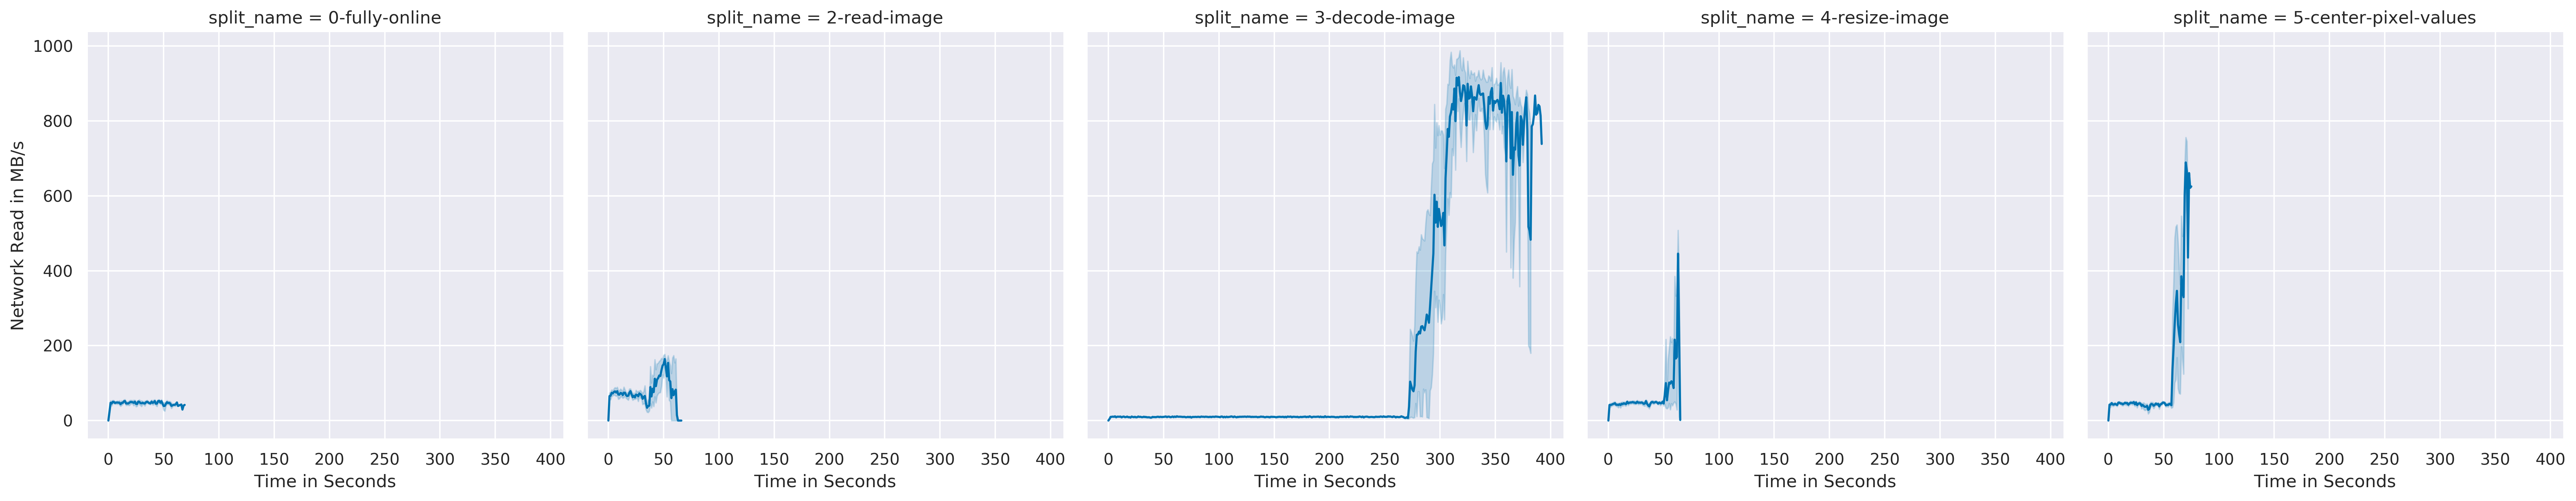

In [35]:
sns.set(palette=default_palette)

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="split_name",
    kind="line",
    data=cum_dstat_df.query(f"thread_count==8 and run==0 and sample_count=={full_dataset_samplecount}"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")

## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [17]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['0-fully-online',
 '2-read-image',
 '3-decode-image',
 '4-resize-image',
 '5-center-pixel-values']

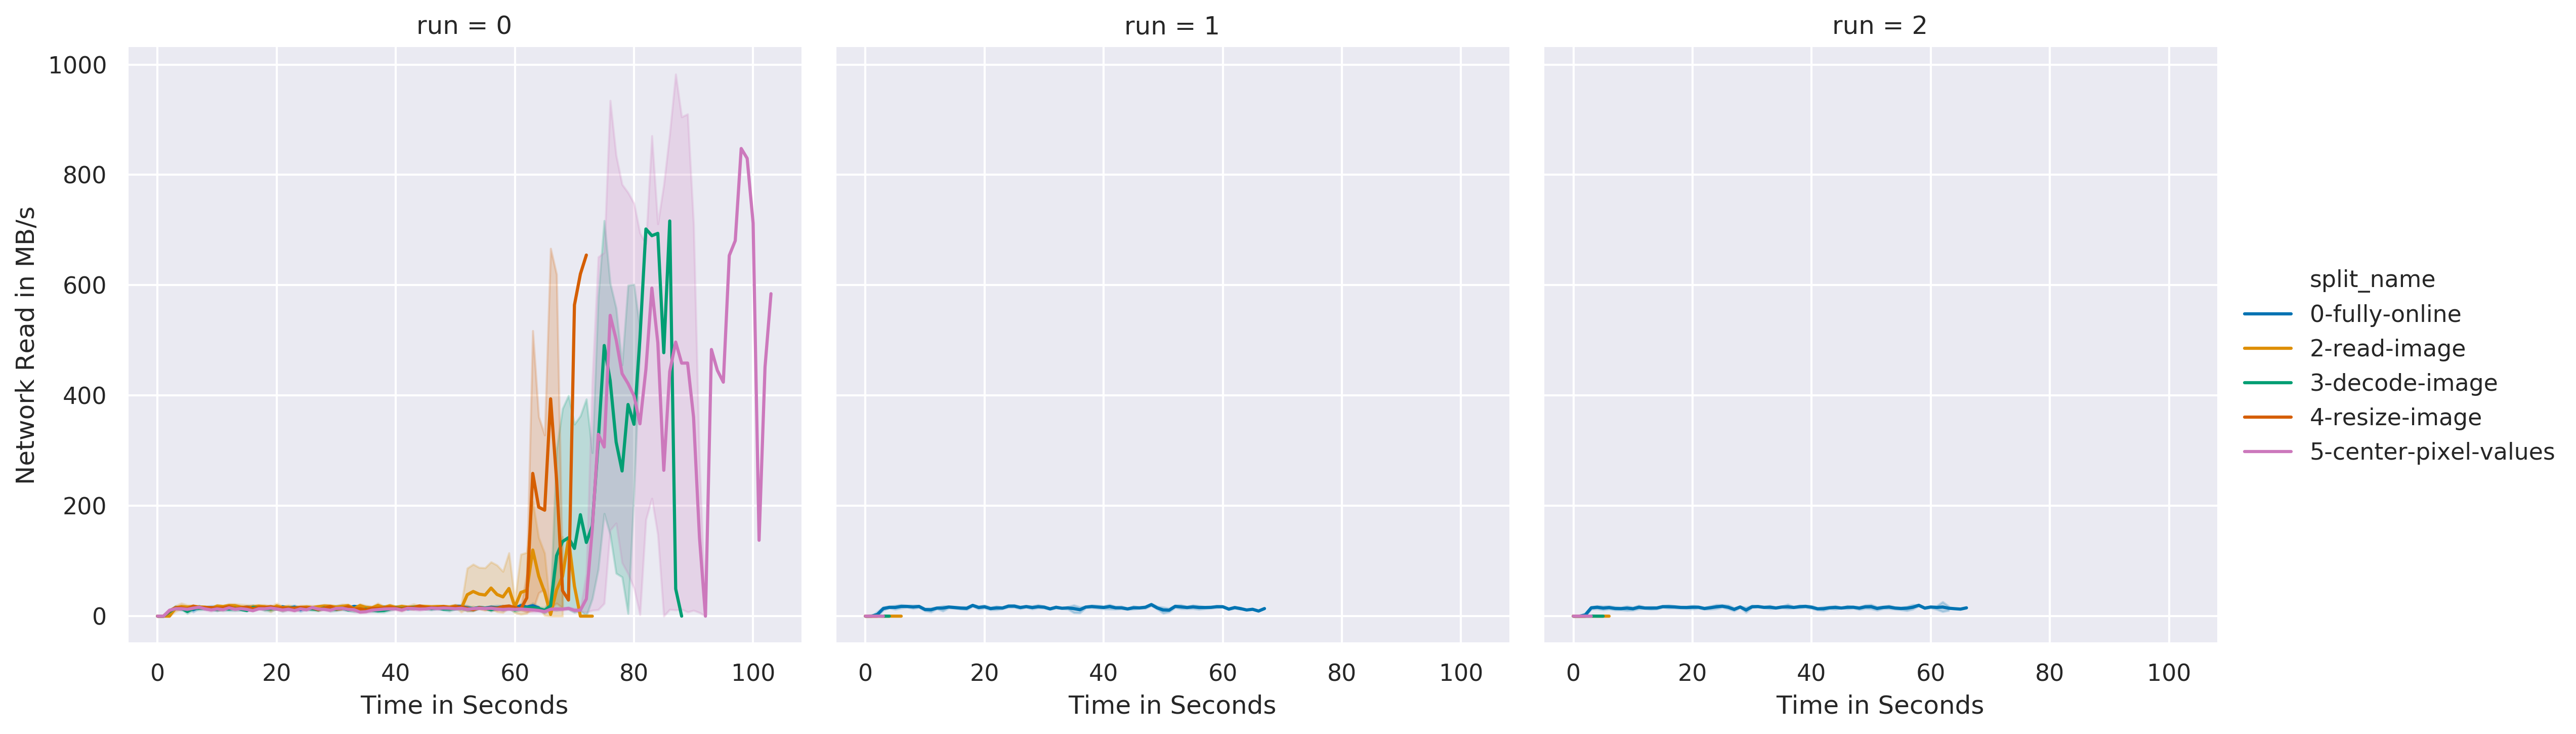

In [193]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              thread_count==8")
plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

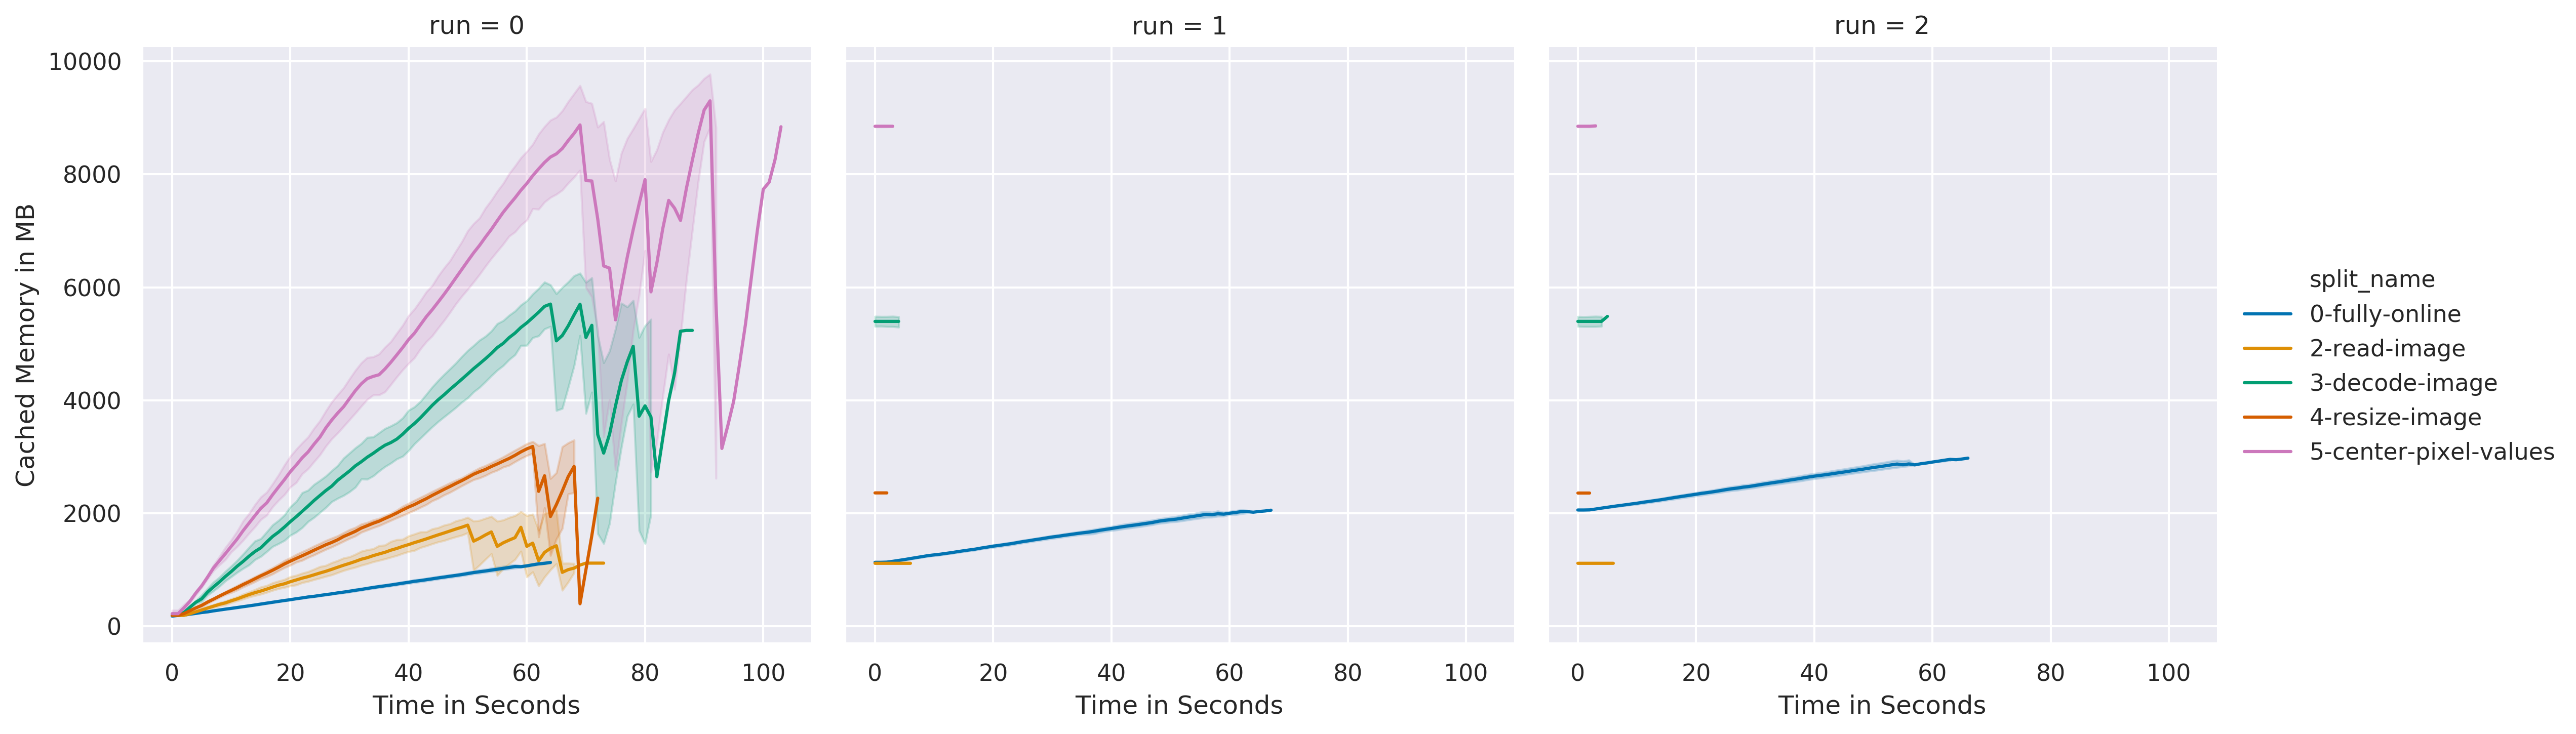

In [194]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              thread_count==8")
plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


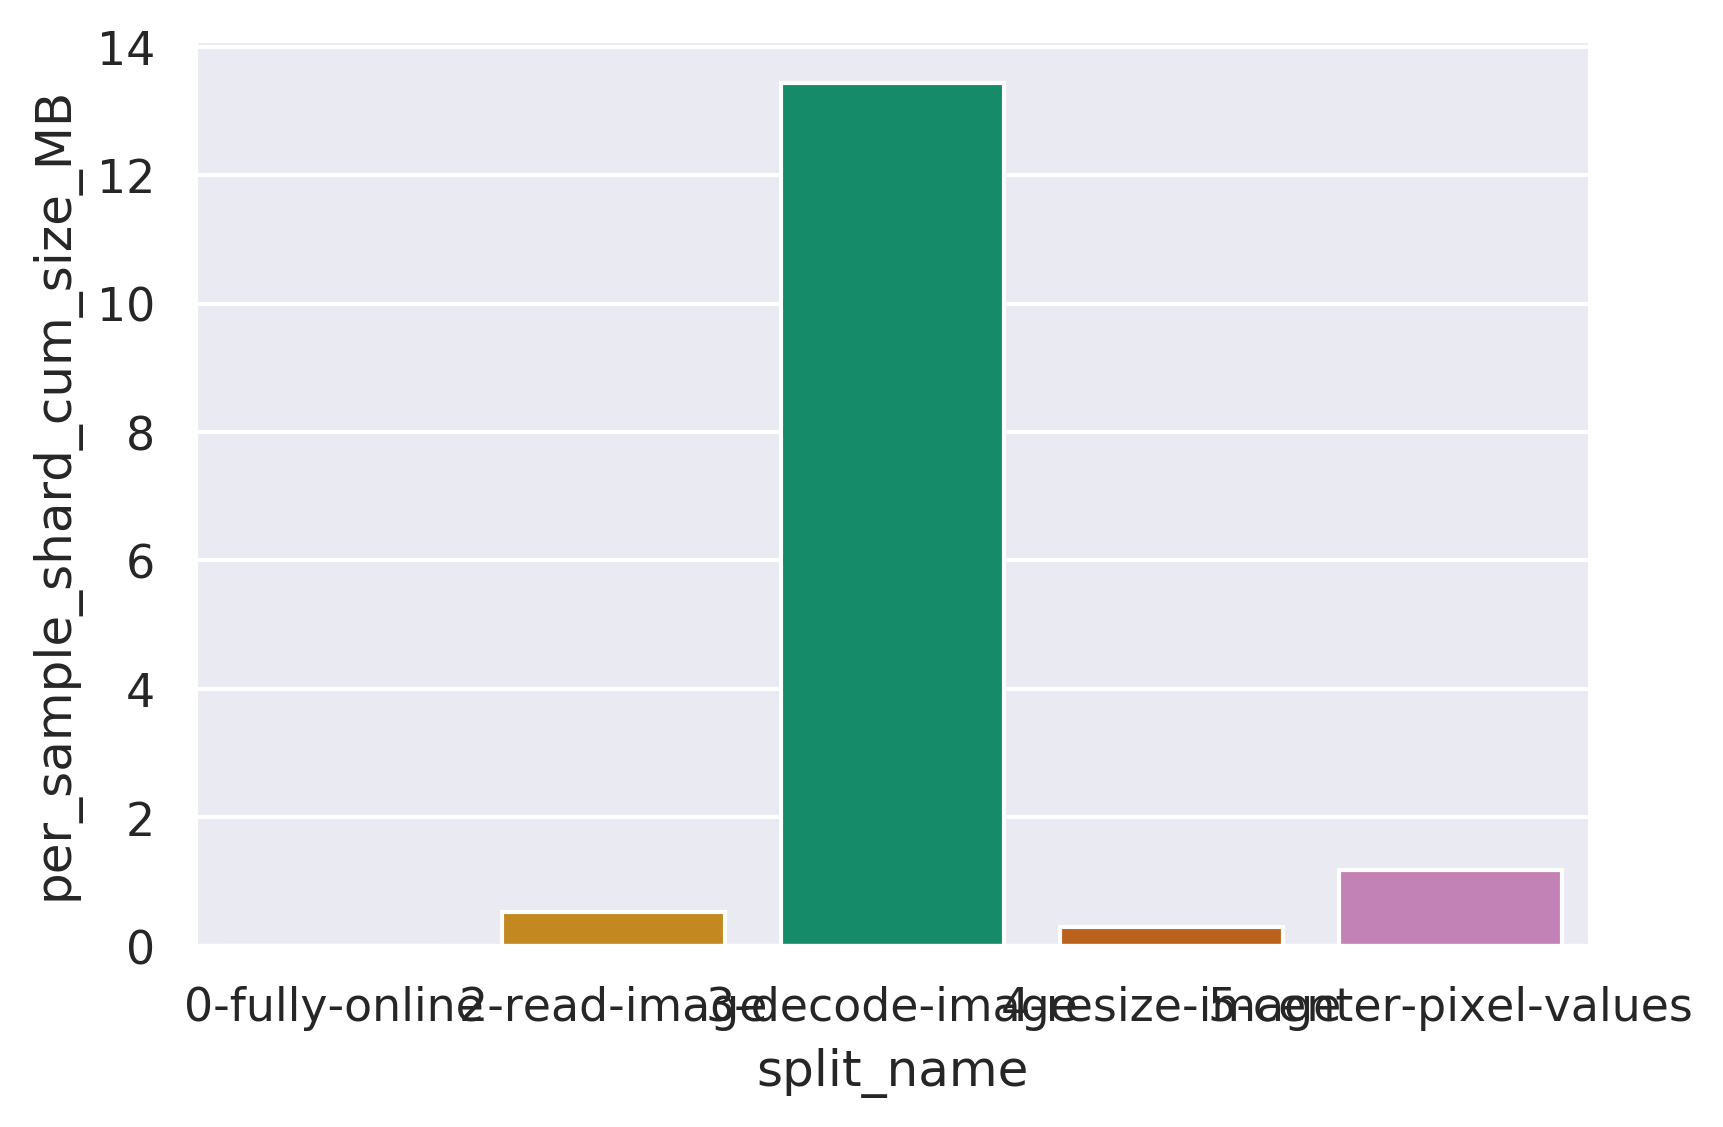

In [41]:
sns.set(palette=default_palette)
import sys

temp_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              runs_count==0")

temp_df["per_sample_shard_cum_size_MB"] = temp_df["shard_cum_size_MB"] / full_dataset_samplecount


plot = sns.barplot(
    x="split_name",
    y="per_sample_shard_cum_size_MB",
    data=temp_df,
    ci=95
)